In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('mental_health_data.csv', index_col=0)

In [6]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [9]:
df.describe()

,statement,status
count,52681,53042
unique,51069,7
top,what do you mean?,Normal
freq,22,16351


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53045 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53042 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [11]:
df.isna().sum()

statement    364
status         3
dtype: int64

In [12]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

In [13]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10651
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

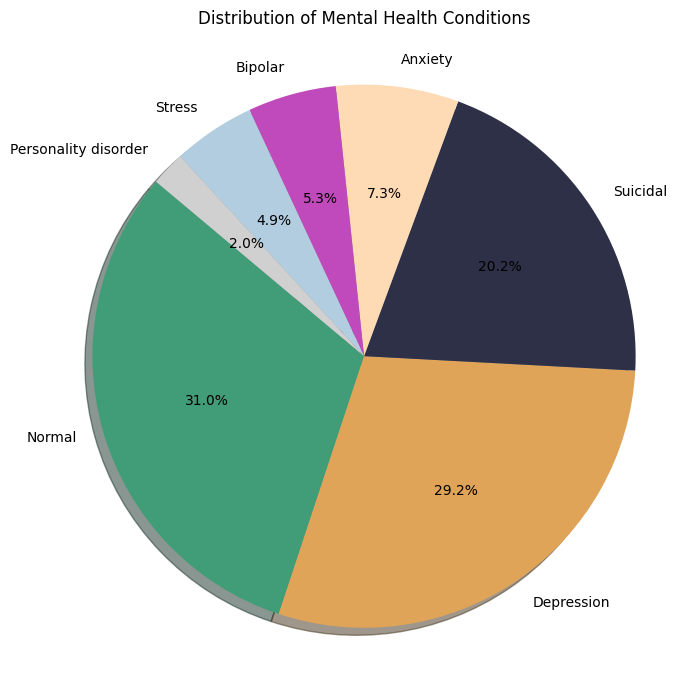

In [15]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()


In [16]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: My whole body is aching like i have the flu I don't know why all of a sudden after almost a week of no symptoms, now my body decides to flip the switch and start all over again...

Yesterday i thought i'm having a heart attack because my left arm was aching all week and then yesterday and even today i had chest pain.

Now it started that my other arm is aching too and my whole body just feels like i have the flu or something. 

Even my mouth feels spicy and weird...

I don't know, is this really something anxiety can do?

I don't feel sick at all, but everything hurts like i'm in full on flu mode.

Pretty much everyone on my mothers side of the family has rheumatism, maybe it's finaly breaking out for me?

Has anyone else felt like you usually do when you are just completely flu struck, only that you aren't actually sick?

Today was the first time i took a magnesium supplement (187 mg) so maybe it has something to do with that?

Status: Bipolar
Statement: i f

In [17]:
# Calculate the number of characters and sentences
nltk.download('punkt_tab')
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


       num_of_characters  num_of_sentences
count       52680.000000      52680.000000
mean          578.086124          6.256112
std           834.590819          9.187351
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         27588.000000        430.000000


In [19]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180
21396,will i ever be noticed? is my life worth anyth...,Depression,12298,160


In [20]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [21]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [22]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [23]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


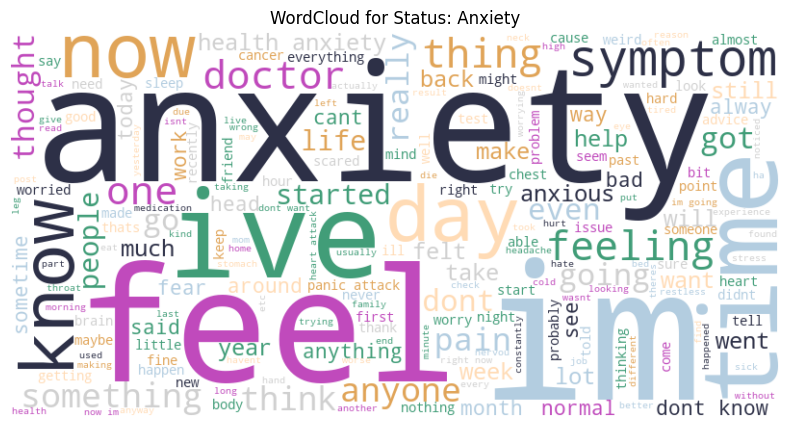

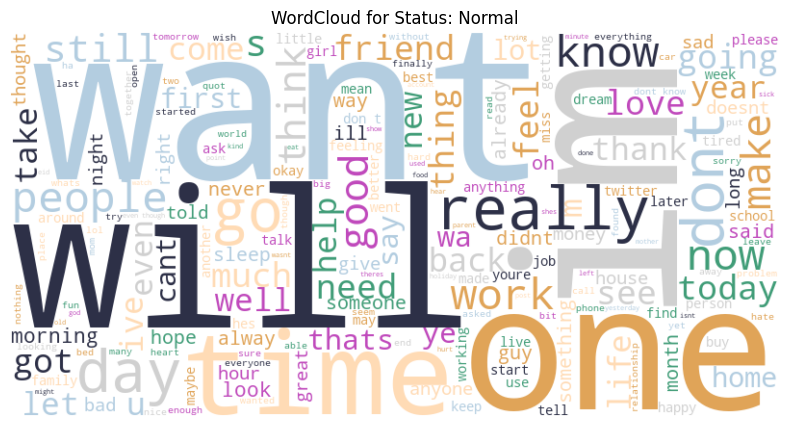

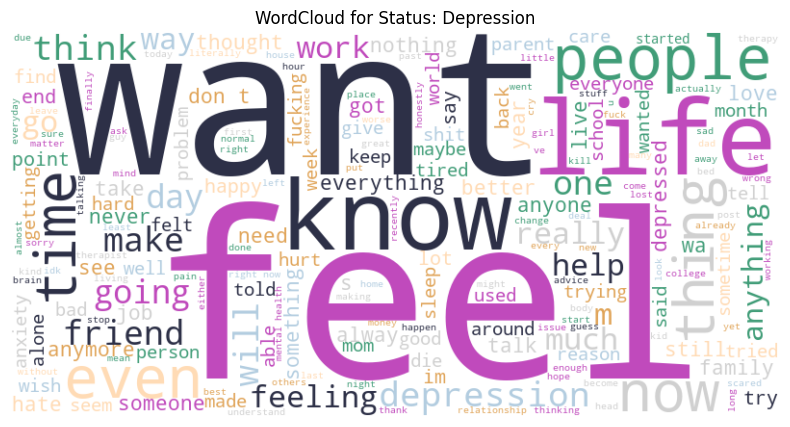

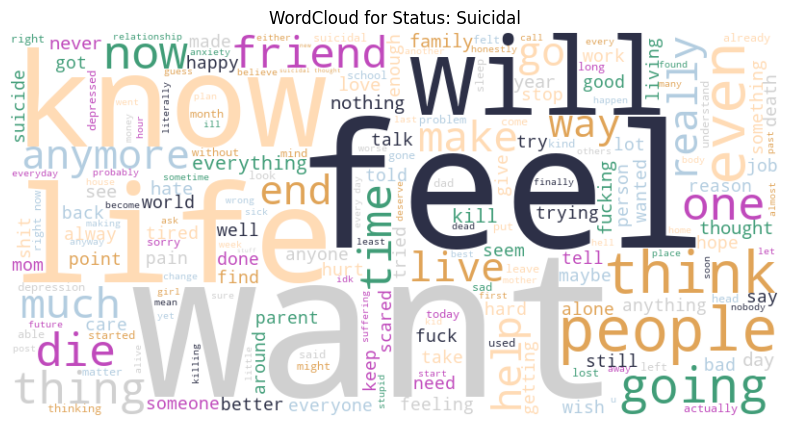

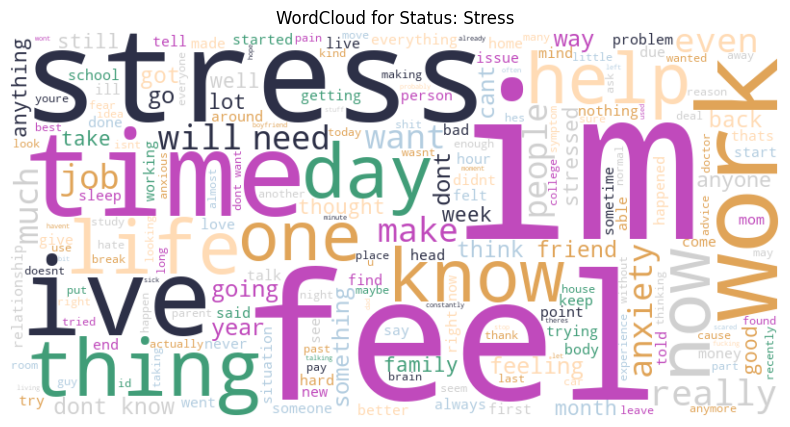

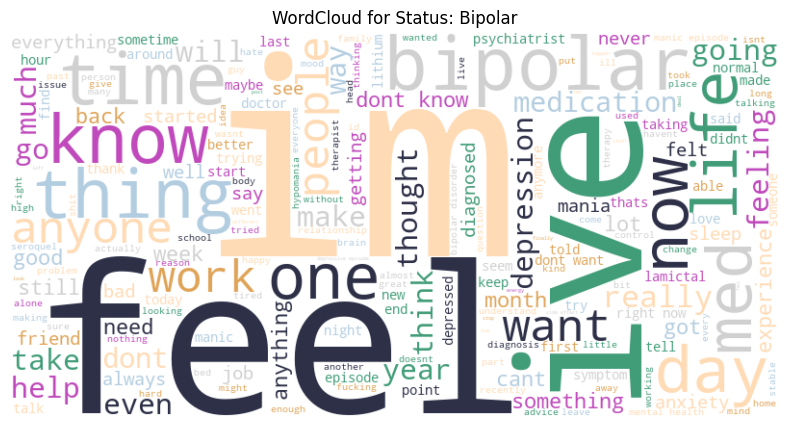

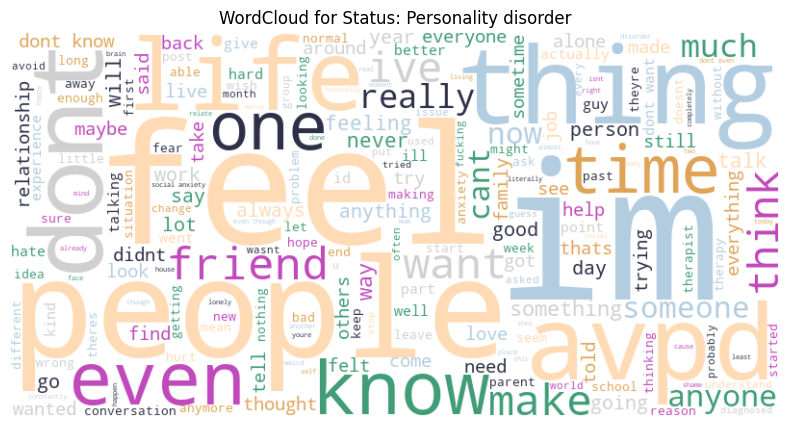

In [25]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [30]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [31]:
from sklearn.preprocessing import LabelEncoder


lbl_enc = LabelEncoder()


y = lbl_enc.fit_transform(y)


print(y)

[0 0 0 ... 0 0 0]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [33]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [34]:
X_train_combined.shape

(42144, 50002)

In [35]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Print the shape to confirm resampling
print(X_train_resampled.shape)


(91434, 50002)


In [36]:
X_train_resampled.shape

(91434, 50002)

XGBoost Accuracy:  0.7941343963553531

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       779
           1       0.85      0.86      0.85       573
           2       0.80      0.67      0.73      3020
           3       0.93      0.91      0.92      3281
           4       0.65      0.75      0.70       212
           5       0.57      0.83      0.68       489
           6       0.67      0.75      0.71      2182

    accuracy                           0.79     10536
   macro avg       0.76      0.80      0.77     10536
weighted avg       0.80      0.79      0.80     10536



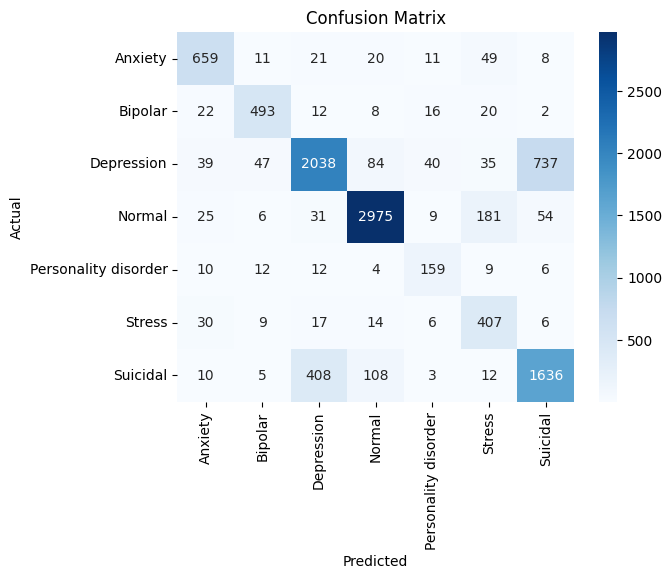

In [37]:
# Importing necessary libraries
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
# Initialize XGBoost classifier
xgb_clf = XGBClassifier(random_state=101)

# Train the classifier
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_clf.predict(X_test_combined)

# Evaluate model performance
print("XGBoost Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix (optional, for additional performance insight)
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [38]:
import re
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Assuming the vectorizer, label encoder, and XGBoost model are already defined and trained

# 1. Preprocess the input text (same steps as in training)
def preprocess_input(text):
    """
    Preprocess the input text in the same way as the training data.
    """
    def remove_patterns(text):
        text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove markdown-style links
        text = re.sub(r'@\w+', '', text)  # Remove handles
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and other special characters
        return text.strip()

    # Step 1: Lowercase the text
    text = text.lower()

    # Step 2: Remove patterns (URLs, handles, etc.)
    text = remove_patterns(text)

    # Step 3: Tokenize the text
    tokens = word_tokenize(text)

    # Step 4: Stem the tokens
    stemmer = PorterStemmer()
    tokens_stemmed = ' '.join(stemmer.stem(str(token)) for token in tokens)

    return tokens_stemmed

# 2. Predicting function
def predict_new_input(input_text):
    # Step 1: Preprocess the new input
    processed_text = preprocess_input(input_text)

    # Step 2: Transform the processed text using the same TF-IDF vectorizer
    processed_tfidf = vectorizer.transform([processed_text])  # Transform into TF-IDF (list format)

    # Step 3: Extract numerical features (like number of characters and sentences)
    num_characters = len(input_text)
    num_sentences = len(nltk.sent_tokenize(input_text))
    numerical_features = np.array([[num_characters, num_sentences]])

    # Step 4: Combine the TF-IDF features with the numerical features
    input_combined = hstack([processed_tfidf, numerical_features])

    # Step 5: Make the prediction using the trained XGBoost model
    prediction = xgb_clf.predict(input_combined)

    # Step 6: Convert the predicted label back to its original category
    predicted_status = lbl_enc.inverse_transform(prediction)

    return predicted_status[0]

# Example usage
new_input = "I feel very overwhelmed and stressed out with my work."
predicted_status = predict_new_input(new_input)
print(f"Predicted Status: {predicted_status}")


Predicted Status: Stress


XGBoost Accuracy: 0.7790432801822323

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       779
           1       0.84      0.86      0.85       573
           2       0.79      0.64      0.71      3020
           3       0.92      0.91      0.91      3281
           4       0.66      0.73      0.69       212
           5       0.51      0.75      0.61       489
           6       0.66      0.74      0.69      2182

    accuracy                           0.78     10536
   macro avg       0.74      0.78      0.76     10536
weighted avg       0.79      0.78      0.78     10536



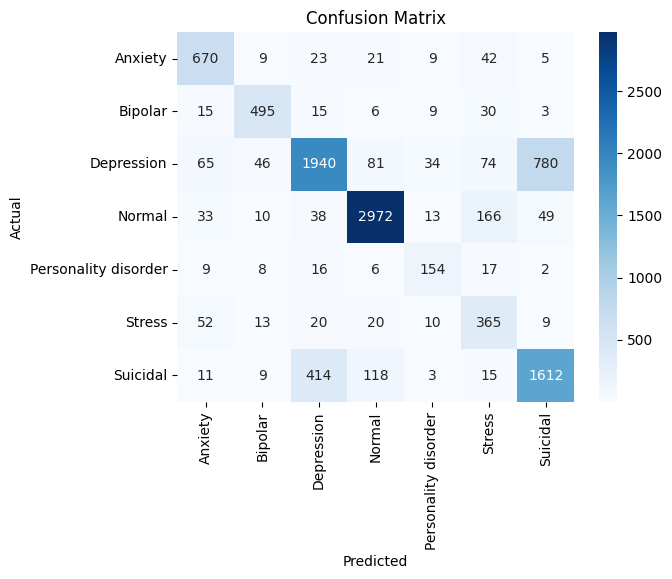

Predicted Status: Stress


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from xgboost import XGBClassifier

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('mental_health_data.csv', index_col=0)

# Data Cleaning
df.dropna(inplace=True)

def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove markdown links
    text = re.sub(r'@\w+', '', text)  # Remove handles
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    return text.strip()

df['statement'] = df['statement'].str.lower().apply(remove_patterns)

# Feature Engineering
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return ' '.join(stemmer.stem(token) for token in tokens)

df['tokens'] = df['statement'].apply(word_tokenize)
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

# Encode labels
lbl_enc = LabelEncoder()
df['status_encoded'] = lbl_enc.fit_transform(df['status'])

# Define features and labels
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status_encoded']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# Combine numerical features with TF-IDF features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

# Oversample the training data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Train the XGBoost model
xgb_clf = XGBClassifier(random_state=101)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predictions and Evaluation
y_pred_xgb = xgb_clf.predict(X_test_combined)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Preprocessing for new inputs
def preprocess_input(text):
    text = text.lower()
    text = remove_patterns(text)
    tokens = word_tokenize(text)
    stemmed_text = ' '.join(PorterStemmer().stem(token) for token in tokens)
    return stemmed_text

# Predict function
def predict_new_input(input_text):
    processed_text = preprocess_input(input_text)
    processed_tfidf = vectorizer.transform([processed_text])
    num_characters = len(input_text)
    num_sentences = len(nltk.sent_tokenize(input_text))
    numerical_features = np.array([[num_characters, num_sentences]])
    input_combined = hstack([processed_tfidf, numerical_features])
    prediction = xgb_clf.predict(input_combined)
    predicted_status = lbl_enc.inverse_transform(prediction)
    return predicted_status[0]

# Test the prediction function
new_input = "I feel very overwhelmed and stressed out with my work."
print(f"Predicted Status: {predict_new_input(new_input)}")


In [2]:
new_input = "I feel very overwhelmed and stressed out with my work."
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Stress


In [3]:
new_input = "I can't stop worrying about everything, even the smallest things make me anxious"
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Anxiety


In [4]:
new_input = "The sadness feels never-ending, and I don't know how to escape it."
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Normal


In [5]:
new_input = "i am happy"
print(f"Predicted Status: {predict_new_input(new_input)}")


Predicted Status: Normal


In [7]:
new_input = " i love eating"
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Normal


In [8]:
new_input = "News revealed that he died by suicide yesterday. "
print(f"Predicted Status: {predict_new_input(new_input)}")


Predicted Status: Suicidal


In [9]:
new_input = "she killed her dog "
print(f"Predicted Status: {predict_new_input(new_input)}")

Predicted Status: Normal
